In [ ]:
#| default_exp activations

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| export

from dlfs.Dataset import *
from dlfs.Learner import *
import math,torch,matplotlib.pyplot as plt
from torch import tensor,nn,no_grad
import torch
import torch.nn.functional as F
import fastcore.all as fc
from torch import optim
from copy import copy
from fastprogress import progress_bar,master_bar

import torchvision.transforms.functional as TF
from torcheval.metrics import MulticlassAccuracy,Mean
from functools import partial


In [ ]:
from datasets import load_dataset,load_dataset_builder
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

Found cached dataset fashion_mnist (/Users/felix/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=0)
dt = dls.train

Found cached dataset fashion_mnist (/Users/felix/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 784]), tensor([0, 1, 8, 8, 3, 9, 2, 8, 8, 2]))

In [ ]:
m,nh,out = 784,50,10
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,out))
loss_func=nn.CrossEntropyLoss()

accuracy,loss,epoch,train
0.611,1.179,0,True
0.720,0.789,0,False
0.742,0.712,1,True
0.767,0.641,1,False
0.778,0.619,2,True
0.786,0.596,2,False


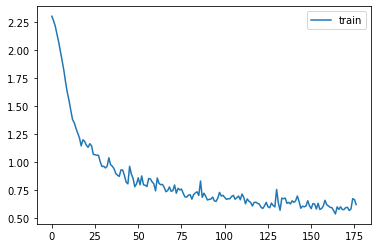

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
train=Learner(model, Core(), dls, [metrics,ProgressCB(plot=True)],F.cross_entropy,lr=0.2)
train.fit(3)

In [ ]:
#| export 
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
    
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats=([],[],[])
    acts=to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,out))
hooks = [Hook(l, append_stats) for l in model[:3].children()]

accuracy,loss,epoch,train
0.611,1.185,0,True
0.714,0.772,0,False
0.743,0.709,1,True
0.749,0.687,1,False
0.782,0.612,2,True
0.799,0.577,2,False


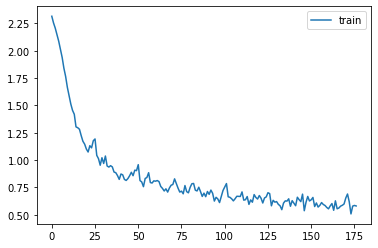

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
train=Learner(model, Core(), dls, [metrics,ProgressCB(plot=True)],F.cross_entropy,lr=0.2)
train.fit(3)

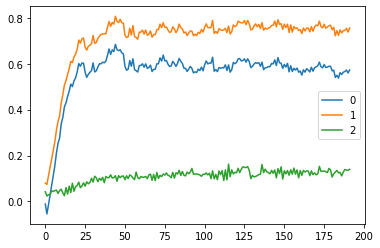

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));
     

In [ ]:
#| export 
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m,f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [ ]:
#| export
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

accuracy,loss,epoch,train
0.598,1.214,0,True
0.685,0.852,0,False
0.744,0.714,1,True
0.743,0.688,1,False
0.783,0.613,2,True
0.777,0.639,2,False


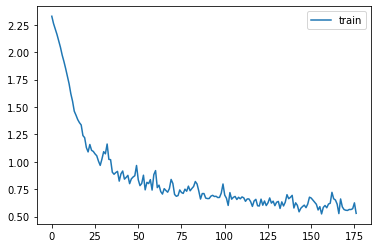

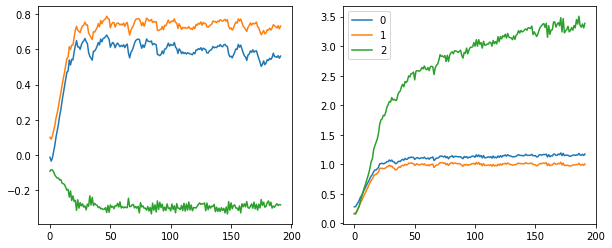

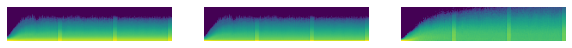

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,out))
with Hooks(model, append_stats) as hooks:
    metrics = MetricsCB(accuracy=MulticlassAccuracy())
    train=Learner(model, Core(), dls, [metrics,ProgressCB(plot=True)],F.cross_entropy,lr=0.2)
    train.fit(3)
    fig,axes=plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        for i in 0,1: axes[i].plot(h.stats[i])
    plt.legend(range(3))
    fig,axes=plt.subplots(1,3,figsize=(10,20))
    for ax,h in zip(axes.flatten(), hooks):
        show_image(get_hist(h), ax, origin='lower')
    
    

In [ ]:
#| export
class HooksCB(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop):
        fc.store_attr()
        super().__init__()
        
    def before_fit(self):
        mods = fc.filter_ex(self.learner.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, self._hookfunc)
        
    def _hookfunc(self, *args, **kwargs):
        if self.learner.model.training: self.hookfunc(*args, **kwargs)
        
    def after_fit(self): 
        self.hooks.remove()
        fig, axs=plt.subplots(1,2, figsize=(10,4))
        for h in hc:
            for i in 0,1: axs[i].plot(h.stats[0])
        fig,axes=plt.subplots(1,len(hooks),figsize=(10,20))
        for ax,h in zip(axes.flatten(), hooks):
            show_image(get_hist(h), ax, origin='lower', figsize=(20,20))
        
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)
    

In [ ]:
hc=HooksCB(append_stats)

accuracy,loss,epoch,train
0.597,1.205,0,True
0.688,0.847,0,False
0.741,0.711,1,True
0.771,0.642,1,False
0.782,0.612,2,True
0.790,0.590,2,False


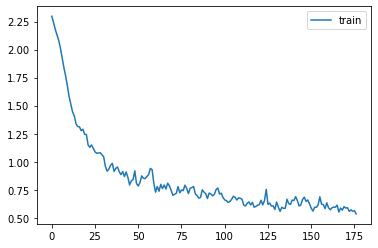

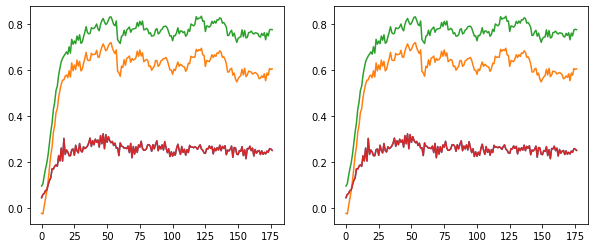

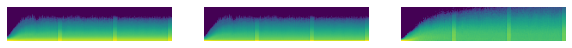

In [ ]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,out))
hc=HooksCB(append_stats)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
train=Learner(model, Core(), dls, [hc,metrics,ProgressCB(plot=True)],F.cross_entropy,lr=0.2)
train.fit(3)

In [ ]:
import nbdev; nbdev.nbdev_export()